In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

image_size = 28
data_path = "F:\QuantumProgrammes\mnist_train.csv"
train_data = np.loadtxt(data_path, delimiter=",")
#test_data = np.loadtxt(data_path + "mnist_test.csv", delimiter=",")

In [2]:
train_data_features = train_data[:10000, 1:]
train_data_labels = train_data[:10000, :1].reshape(10000,)

In [3]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
# Using SVD to bring down the dimension to 10
tsvd = TruncatedSVD(n_components=10)
X_SVD = tsvd.fit_transform(train_data_features)

# Further using t-SNE to bring the dimension down to 2
np.random.seed(0)
tsne = TSNE(n_components=2)
train_data_features_reduced = tsne.fit_transform(X_SVD)

In [4]:
print("Dimension of the reduced dataset: {}".format(train_data_features_reduced.shape[1]))

Dimension of the reduced dataset: 2


In [5]:
import seaborn as sns
import pandas as pd

# function to help plot the 2-D dataset
def plot2d(X, Y, c1, c2, N):
    lbl1 = f'Component {c1}'
    lbl2 = f'Component {c2}'    
    df = pd.DataFrame({lbl1:X[:N,c1], lbl2:X[:N,c2], 'label':Y[:N]})
    sns.lmplot(data=df, x=lbl1, y=lbl2, fit_reg=False, hue='label', scatter_kws={'alpha':0.5})

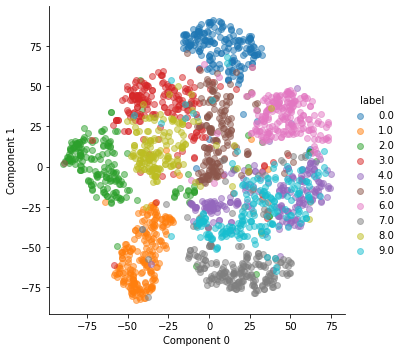

In [6]:
plot2d(train_data_features_reduced, train_data_labels, 0, 1, N=2000)

In [7]:
three_datapoints = []
eight_datapoints = []
for i in range(10000):
    if train_data_labels[i] == 3:                   # extracting zeros
        three_datapoints.append(train_data_features_reduced[i])

for i in range(10000):
    if train_data_labels[i] == 8:                   # extracting ones
        eight_datapoints.append(train_data_features_reduced[i])
        
three_datapoints = np.array(three_datapoints)
eight_datapoints = np.array(eight_datapoints)

def normalize(arr, max_val, n):
    a = np.divide(arr, max_val)
    return a + n

three_datapoints_normalized = normalize(three_datapoints, 100, 1)
eight_datapoints_normalized = normalize(eight_datapoints, 100, 1)

In [8]:
from qiskit import *
import numpy as np

import time
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQC


<h2>Training data</h2>

In [10]:
train_size = 20
test_size = 10
dp_size_three = 5
dp_size_eight = 5

three_train = three_datapoints_normalized[:train_size]
eight_train = eight_datapoints_normalized[:train_size]

three_test = three_datapoints_normalized[train_size + 1:train_size + test_size + 1]
eight_test = eight_datapoints_normalized[train_size + 1:train_size + test_size + 1]

training_input = {'A':three_train, 'B':eight_train}
test_input = {'A':three_test, 'B':eight_test}

# datapoints is our validation set
datapoints = []
dp_three = three_datapoints_normalized[train_size + test_size + 2:train_size + test_size + 2 + dp_size_three]
dp_eight = eight_datapoints_normalized[train_size + test_size + 2:train_size + test_size + 2 + dp_size_eight]
datapoints.append(np.concatenate((dp_three, dp_eight)))
dp_y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
datapoints.append(dp_y)

class_to_label = {'A': 0, 'B': 1}

<h2>Custom Feature Map</h2>

In [3]:
from qiskit.circuit import QuantumCircuit, ParameterVector
import numpy as np
seed = 10598
num_qubits = 2
reps = 2              # number of times you'd want to repeat the circuit

x = ParameterVector('x', length=num_qubits)  # creating a list of Parameters
custom_circ = QuantumCircuit(num_qubits)

# defining our parametric form

for _ in range(reps):
    for i in range(num_qubits):
        custom_circ.h(i)
        custom_circ.u1(2*((np.pi/2-x[i]) * (np.pi/2-x[i])), i)
        custom_circ.h(i)
    for i in range(num_qubits):
        for j in range(i + 1, num_qubits):
            custom_circ.cx(i, j)
            custom_circ.u1(2*((np.pi-x[i]) * (np.pi-x[j])), j)
            custom_circ.cx(i, j)

custom_circ.draw()

┌───┐┌──────────────────────────────────────────────────────┐┌───┐     »
q_0: ┤ H ├┤ U1(4.93480220054468*(1 - 0.636619772367581*x[0])**2) ├┤ H ├──■──»
     ├───┤├──────────────────────────────────────────────────────┤├───┤┌─┴─┐»
q_1: ┤ H ├┤ U1(4.93480220054468*(1 - 0.636619772367581*x[1])**2) ├┤ H ├┤ X ├»
     └───┘└──────────────────────────────────────────────────────┘└───┘└───┘»
«                                                                       ┌───┐»
«q_0: ───────────────────────────────────────────────────────────────■──┤ H ├»
«     ┌───────────────────────────────────────────────────────────┐┌─┴─┐├───┤»
«q_1: ┤ U1(2*(3.14159265358979 - x[0])*(3.14159265358979 - x[1])) ├┤ X ├┤ H ├»
«     └───────────────────────────────────────────────────────────┘└───┘└───┘»
«     ┌──────────────────────────────────────────────────────┐┌───┐     »
«q_0: ┤ U1(4.93480220054468*(1 - 0.636619772367581*x[0])**2) ├┤ H ├──■──»
«     ├──────────────────────────────────────────────────────┤├───┤┌─┴─┐»
«q_1: ┤ U1(4.93480220054468*(1 - 0.636619772367581*x[1])**2) ├┤ H ├┤ X ├»
«     └──────────────────────────────────────────────────────┘└───┘└───┘»
«                                                                       
«q_0: ───────────────────────────────────────────────────────────────■──
«     ┌───────────────────────────────────────────────────────────┐┌─┴─┐
«q_1: ┤ U1(2*(3.14159265358979 - x[0])*(3.14159265358979 - x[1])) ├┤ X ├
«     └───────────────────────────────────────────────────────────┘└───┘

In [12]:
from qiskit.aqua.components.optimizers import COBYLA

cobyla = COBYLA(maxiter=500, tol=0.001)

In [14]:
from qiskit.circuit.library import EfficientSU2, RealAmplitudes

var = EfficientSU2(num_qubits, reps=2)
var.draw()

┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐     ┌──────────┐»
q_0: ┤ RY(θ[0]) ├┤ RZ(θ[2]) ├──■──┤ RY(θ[4]) ├┤ RZ(θ[6]) ├──■──┤ RY(θ[8]) ├»
     ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤┌─┴─┐├──────────┤»
q_1: ┤ RY(θ[1]) ├┤ RZ(θ[3]) ├┤ X ├┤ RY(θ[5]) ├┤ RZ(θ[7]) ├┤ X ├┤ RY(θ[9]) ├»
     └──────────┘└──────────┘└───┘└──────────┘└──────────┘└───┘└──────────┘»
«     ┌───────────┐
«q_0: ┤ RZ(θ[10]) ├
«     ├───────────┤
«q_1: ┤ RZ(θ[11]) ├
«     └───────────┘

In [15]:
def call_back_vqc(eval_count, var_params, eval_val, index):
    print("eval_count: {}".format(eval_count))
    print("var_params: {}".format(var_params))
    print("eval_val: {}".format(eval_val))
    print("index: {}".format(index))

In [16]:
# initilizing our backend
backend = BasicAer.get_backend('qasm_simulator')
backend_options = {"method": "statevector"}

# creating a quantum instance
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed, backend_options=backend_options)

#initilizing our VQC object
vqc = VQC(optimizer=cobyla, feature_map=custom_circ, var_form=var, callback=call_back_vqc, training_dataset=training_input, 
         test_dataset=test_input, datapoints=datapoints[0])

In [17]:
start = time.process_time()

result = vqc.run(quantum_instance)

print("time taken: ")
print(time.process_time() - start)


print("testing success ratio: {}".format(result['testing_accuracy']))

eval_count: 0
var_params: [ 3.30045889e-01 -4.79979434e-04  8.18115898e-01  4.28213708e-01
 -2.50394732e+00  1.20481133e-01  8.07892857e-01  6.02120978e-01
 -8.65190000e-01 -1.53320351e-01 -2.40490559e-01 -6.07633463e-02]
eval_val: 0.6853283104347868
index: 0
eval_count: 1
var_params: [ 1.33004589e+00 -4.79979434e-04  8.18115898e-01  4.28213708e-01
 -2.50394732e+00  1.20481133e-01  8.07892857e-01  6.02120978e-01
 -8.65190000e-01 -1.53320351e-01 -2.40490559e-01 -6.07633463e-02]
eval_val: 0.7712155931145434
index: 1
eval_count: 2
var_params: [ 0.33004589  0.99952002  0.8181159   0.42821371 -2.50394732  0.12048113
  0.80789286  0.60212098 -0.86519    -0.15332035 -0.24049056 -0.06076335]
eval_val: 0.6853283104347868
index: 2
eval_count: 3
var_params: [ 3.30045889e-01 -4.79979434e-04  1.81811590e+00  4.28213708e-01
 -2.50394732e+00  1.20481133e-01  8.07892857e-01  6.02120978e-01
 -8.65190000e-01 -1.53320351e-01 -2.40490559e-01 -6.07633463e-02]
eval_val: 0.6853283104347868
index: 3
eval_coun

eval_count: 32
var_params: [-1.73495523e-01 -4.79979434e-04  8.18115898e-01  1.40226424e+00
 -1.24768689e+00  1.13273950e+00  1.23929244e+00  1.56007431e+00
 -6.20058004e-01  5.71849040e-01 -2.49924340e-01 -1.55615743e-01]
eval_val: 0.43215272897947454
index: 32
eval_count: 33
var_params: [-2.94766716e-01 -4.79979434e-04  8.18115898e-01  1.41949868e+00
 -1.26093632e+00  1.12830112e+00  1.37085269e+00  1.35140137e+00
 -6.27524706e-01  6.01007438e-01 -2.79744449e-01 -1.38932629e-01]
eval_val: 0.41895358314211145
index: 33
eval_count: 34
var_params: [-1.44776416e-01 -4.79979434e-04  8.18115898e-01  1.39560848e+00
 -1.26372299e+00  1.14792367e+00  1.37116313e+00  1.33084525e+00
 -5.42362369e-01  6.00035328e-01 -2.84469570e-01  7.85504027e-02]
eval_val: 0.42180418466907443
index: 34
eval_count: 35
var_params: [-0.17036003  0.12452002  0.8181159   1.42044244 -1.26059574  1.12737918
  1.37031045  1.35281386 -0.63170413  0.60061602 -0.27905589 -0.15014581]
eval_val: 0.41845504131684114
index: 

eval_count: 69
var_params: [-0.19962787 -0.07893725  0.88276012  1.35144521 -1.34344446  1.02032186
  1.36741278  1.33530569 -0.69789561  0.55085504 -0.39718667 -0.14528333]
eval_val: 0.41211448504979503
index: 69
eval_count: 70
var_params: [-0.2000981  -0.07863123  0.90378868  1.35071026 -1.34347928  1.01782291
  1.34924046  1.32304495 -0.70444523  0.55099582 -0.39691753 -0.14335647]
eval_val: 0.4122136171956865
index: 70
eval_count: 71
var_params: [-0.2064029  -0.07568724  0.88711467  1.34498042 -1.34642771  1.0230063
  1.35880229  1.3265716  -0.64613417  0.5437173  -0.39822832 -0.17513665]
eval_val: 0.4140858218522189
index: 71
eval_count: 72
var_params: [-0.19540071 -0.07911773  0.88509211  1.35167546 -1.35054967  1.02665254
  1.35308355  1.35844914 -0.69663764  0.54489632 -0.40619038 -0.14341078]
eval_val: 0.4135621881645169
index: 72
eval_count: 73
var_params: [-0.20713657 -0.07345298  0.87393043  1.33766153 -1.29939037  1.00627287
  1.38382666  1.31688502 -0.71719335  0.53832809

eval_count: 108
var_params: [-0.19606487 -0.09565684  0.88109028  1.3620137  -1.34622257  1.03038056
  1.37225679  1.32840219 -0.69845701  0.56714029 -0.39533554 -0.13488484]
eval_val: 0.41206312174515014
index: 108
eval_count: 109
var_params: [-0.19794243 -0.09541809  0.88064738  1.36163558 -1.3471139   1.03063453
  1.37270717  1.32467188 -0.69750363  0.56583677 -0.39379906 -0.13458946]
eval_val: 0.4117932984296043
index: 109
eval_count: 110
var_params: [-0.19784414 -0.09618118  0.88124477  1.36234969 -1.34634817  1.0298935
  1.3722318   1.3252719  -0.69793988  0.56619126 -0.39436138 -0.13556718]
eval_val: 0.4117067085152904
index: 110
eval_count: 111
var_params: [-0.19722338 -0.09666771  0.88124044  1.36235501 -1.34559077  1.03047988
  1.3735183   1.32538748 -0.69776352  0.56532885 -0.39322274 -0.13601108]
eval_val: 0.4116889159415318
index: 111
eval_count: 112
var_params: [-0.1976122  -0.09642246  0.88140912  1.3621161  -1.34692837  1.0302742
  1.37235238  1.32583258 -0.69722235  0.

In [18]:
print("prediction of datapoints:")
print("ground truth: {}".format(map_label_to_class_name(datapoints[1], vqc.label_to_class)))
print("prediction:   {}".format(result['predicted_classes']))

prediction of datapoints:
ground truth: ['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B']
prediction:   ['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B']
